In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install efficientnet

In [ ]:
%tensorflow_version 2.x

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, GlobalAveragePooling2D, Activation
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
import efficientnet.tfkeras as efn
import tensorflow.keras.callbacks as cb
import tensorflow.keras.layers as L
import tensorflow.keras as K
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os, zipfile
from tqdm.auto import tqdm

# 載入資料

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 100 * 4 // BATCH_SIZE
STEPS = 128
NUM_CLASSES = 3
DATASET_PATH = '/content/datasets/'

In [ ]:
if not os.path.exists('datasets'):
    f = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/datasets-300.zip")
    f.extractall("./")

# CNN、FC 模型建立

In [ ]:
def convert_to_numpy(x_data):
    class_map = {'A': 0, 'B': 1, 'C': 2}
    train_datas = np.zeros((len(x_data), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
    train_label = np.zeros(len(x_data), dtype=np.float32)

    for i, path in enumerate(x_data):
        img = cv2.imread(path)
        img = img[:, :, ::-1]
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        c = path.split('/')[-2]
        train_datas[i] = img
        train_label[i] = class_map[c]

    # train_label = to_categorical(train_label, NUM_CLASSES)
    return train_datas, train_label

x_train = sorted(glob('/content/datasets/train/*/*.jpg'))
x_test = sorted(glob('/content/datasets/test/*/*.jpg'))

x_train_np, y_train_np = convert_to_numpy(x_train)
x_test_np, y_test_np = convert_to_numpy(x_test)

x_test_np /= 255.0

In [ ]:
trn_dagen = ImageDataGenerator(rescale = 1.0 / 255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               channel_shift_range=10,
                               horizontal_flip=True,
                               vertical_flip=True, 
                               brightness_range=[0.5, 1.5],
                               fill_mode='nearest')

trn_dagen.fit(x_train_np)

In [ ]:
enet = efn.EfficientNetB7(weights='noisy-student', 
                          include_top=False,
                          input_shape=x_train_np[0].shape)

for layer in enet.layers:
    layer.trainable = True
  
model = Sequential()
model.add(enet)
model.add(GlobalAveragePooling2D())
model.add(Dense(3, activation="softmax"))

In [ ]:
model.compile(loss=K.losses.SparseCategoricalCrossentropy(), 
              optimizer=K.optimizers.Adam(), 
              metrics=[K.metrics.SparseCategoricalAccuracy()])

In [ ]:
LR_START = 0.0001
LR_MAX = 0.00005
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = cb.LearningRateScheduler(lrfn, verbose=True)

rl_callback = cb.ReduceLROnPlateau(monitor = "val_loss", 
                                   factor = 0.5, 
                                   patience = 10, 
                                   verbose = 0, 
                                   mode = "auto", 
                                   min_delta = 1e-07, 
                                   cooldown = 0, 
                                   min_lr = 1e-7)

es_callback = cb.EarlyStopping(patience=15, restore_best_weights=True)

# rng = [i for i in range(NUM_EPOCHS)]
# y = [lrfn(x) for x in rng]
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

callbacks = [lr_callback, 
             rl_callback, 
             es_callback]

In [ ]:
history = model.fit(datagen.flow(x_train_np, y_train_np, batch_size=10),
                    steps_per_epoch= len(x_train_np) // 10,
                    epochs=48,
                    verbose=1,
                    validation_data=(x_test_np, y_test_np),
                    callbacks=callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/48
139/139 [==============================] - 63s 456ms/step - loss: 0.9877 - accuracy: 0.5051 - val_loss: 1.1086 - val_accuracy: 0.6160 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 8.75e-05.
Epoch 2/48
139/139 [==============================] - 58s 420ms/step - loss: 0.7681 - accuracy: 0.6546 - val_loss: 0.6472 - val_accuracy: 0.7421 - lr: 8.7500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 7.500000000000001e-05.
Epoch 3/48
139/139 [==============================] - 58s 420ms/step - loss: 0.6861 - accuracy: 0.7146 - val_loss: 0.5440 - val_accuracy: 0.7765 - lr: 7.5000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 4/48
139/139 [==============================] - 58s 419ms/step - loss: 0.6342 - accuracy: 0.7392 - val_loss: 0.4999 - val_accuracy: 0.7937 - lr: 6.2500e-05

Epoch 00005: LearningRateScheduler reducing learning

# Plot accuracy

Text(0.5, 1.0, 'acc')

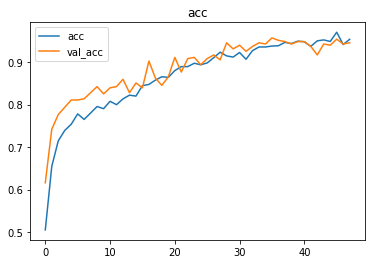

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

# Plot loss 

Text(0.5, 1.0, 'loss')

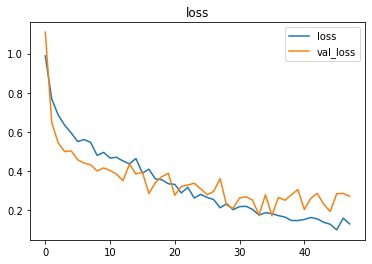

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

# 評估模型

In [ ]:
from tensorflow.keras.models import load_model

accuracy_B6 = model.evaluate(x_test_np, y_test_np)
accuracy_B6

11/11 [==============================] - 2s 194ms/step - loss: 0.2720 - accuracy: 0.9456


[0.271955668926239, 0.9455587267875671]

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

pre = model.predict(x_test_np)
pre = pre.argmax(axis=-1)

ori_class = np.argmax(y_test_np, axis=-1)

ori_class = np.argmax(y_test_np, axis=-1)
df = pd.DataFrame(confusion_matrix(ori_class, pre))
df